In [1]:
import torch
import matplotlib.pyplot as plt
import glob
from utils import imageSize
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchmetrics import Accuracy
from torch.utils.tensorboard import SummaryWriter


In [ ]:

# Assuming you want to create a DataLoader for image datasets
transform = transforms.Compose([
    transforms.Resize((imageSize, imageSize)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])



# Create a dataset and dataloader
dataset = datasets.ImageFolder('data', transform=transform)
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
val_size = test_size // 2
test_size = test_size - val_size
batch_size = 32
num_workers = torch.get_num_threads()
train_dataset,val_dataset ,test_dataset = random_split(dataset, [train_size, val_size,test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [3]:
clases = dataset.classes
classes =[longClass.split('-')[0] for longClass in dataset.classes]

In [4]:
@torch.no_grad()
def showImages(images,labels,predLabels=None):
    fig = plt.figure(figsize=(10,10))
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(images[i].permute(1, 2, 0))
        tlt = classes[labels[i]] if predLabels is None else f'Target: {classes[labels[i]]} \nPrediction{classes[predLabels[i]]}'
        plt.title(tlt)
        plt.axis('off')
    return fig

In [5]:
images, labels = next(iter(val_loader))
print(images.shape, labels.shape)

torch.Size([32, 3, 128, 128]) torch.Size([32])


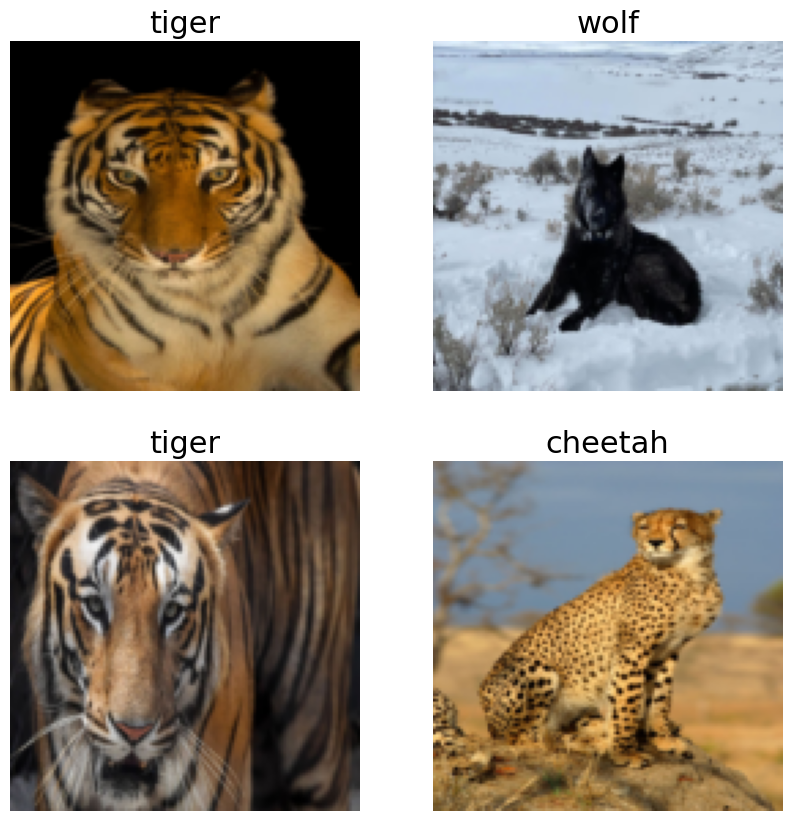

In [6]:
_ = showImages(images, labels)

# Create model

In [7]:
from model_zoo import animalModel,Animal2

In [8]:
num_classes = len(classes)
model = Animal2(3, num_classes)
num_epochs = 60
valSteps = len(val_loader)
writer = SummaryWriter(comment='Best model with GELU')
lossF = nn.CrossEntropyLoss()
learningRate = 1e-3
momentum = 0.9
optimizer = optim.SGD(model.parameters(), lr=learningRate, momentum=momentum)
accMetric = Accuracy(task='multiclass',num_classes=num_classes)
writer.add_hparams({'lr':learningRate,'optim':'SGD','Batch Size':batch_size,'momentum':momentum,'image size':imageSize,'train ratio':train_size*100/len(dataset),'validation ratio':val_size*100/len(dataset),'test ratio':test_size*100/len(dataset)},{'Number of epochs':num_epochs})

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trainsteps  = len(train_loader)

In [10]:
model = model.to(device)
writer.add_graph(model, images.to(device))
accMetric.to(device)

MulticlassAccuracy()

In [11]:
model.fit(train_loader,val_loader,criterion=lossF,optimizer=optimizer,device=device,writer=writer,accMetric=accMetric,epochs=num_epochs)

Epoch: 0
Training Loss: 1.7424 Training Accuracy: 0.2641
Validation Loss: 1.724526047706604 Validation Accuracy: 0.2430555522441864
Epoch: 1
Training Loss: 1.6348 Training Accuracy: 0.4178
Validation Loss: 1.6595579385757446 Validation Accuracy: 0.3194444477558136
Epoch: 2
Training Loss: 1.5472 Training Accuracy: 0.4874
Validation Loss: 1.5933380126953125 Validation Accuracy: 0.4618055522441864
Epoch: 3
Training Loss: 1.4822 Training Accuracy: 0.5784
Validation Loss: 1.6243422031402588 Validation Accuracy: 0.3611111044883728
Epoch: 4
Training Loss: 1.4403 Training Accuracy: 0.6241
Validation Loss: 1.479241967201233 Validation Accuracy: 0.5659722089767456
Epoch: 5
Training Loss: 1.4175 Training Accuracy: 0.6434
Validation Loss: 1.5109387636184692 Validation Accuracy: 0.5451388955116272
Epoch: 6
Training Loss: 1.4119 Training Accuracy: 0.6409
Validation Loss: 1.5630168914794922 Validation Accuracy: 0.46875
Epoch: 7
Training Loss: 1.3552 Training Accuracy: 0.7219
Validation Loss: 1.465479

KeyboardInterrupt: 